In [15]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import umap

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.18.2 scipy==1.5.0 pandas==0.25.3 scikit-learn==0.23.1 statsmodels==0.11.1


In [3]:
E14_hom = sc.read('../data/E14_hom.csv', cache=True)
E14_hom = sc.AnnData(E14_hom).transpose()
print(E14_hom)

... reading from cache file cache/..-data-E14_hom.h5ad
AnnData object with n_obs × n_vars = 4446 × 30213


normalizing counts per cell
    finished (0:00:00)


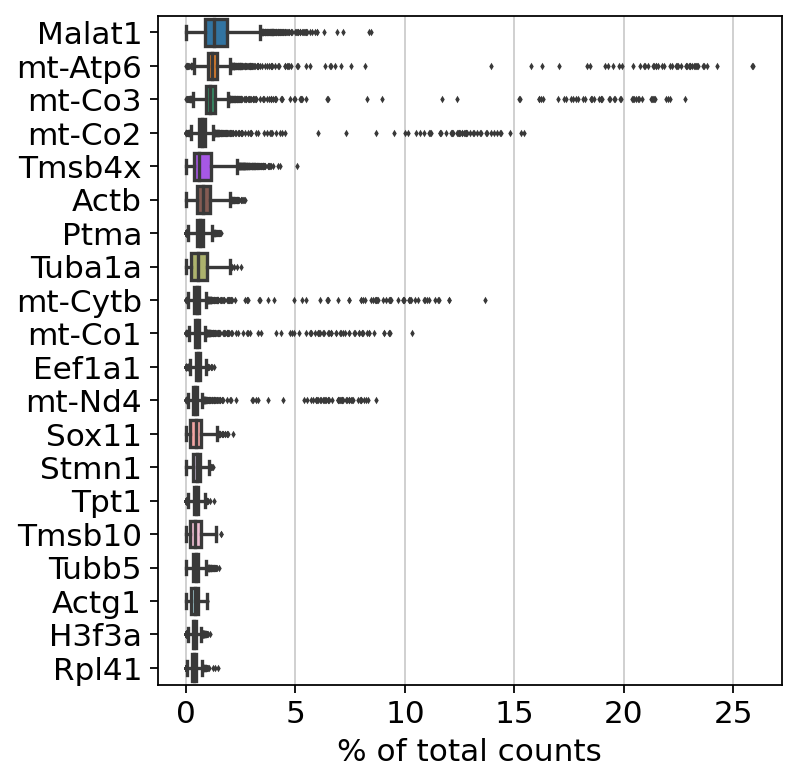

filtered out 44 cells that have less than 200 genes expressed
filtered out 13314 genes that are detected in less than 3 cells
AnnData object with n_obs × n_vars = 4402 × 16899
    obs: 'n_genes'
    var: 'n_cells'


In [7]:
sc.pl.highest_expr_genes(E14_hom, n_top=20, )
sc.pp.filter_cells(E14_hom, min_genes=200)
sc.pp.filter_genes(E14_hom, min_cells=3)
print(E14_hom)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

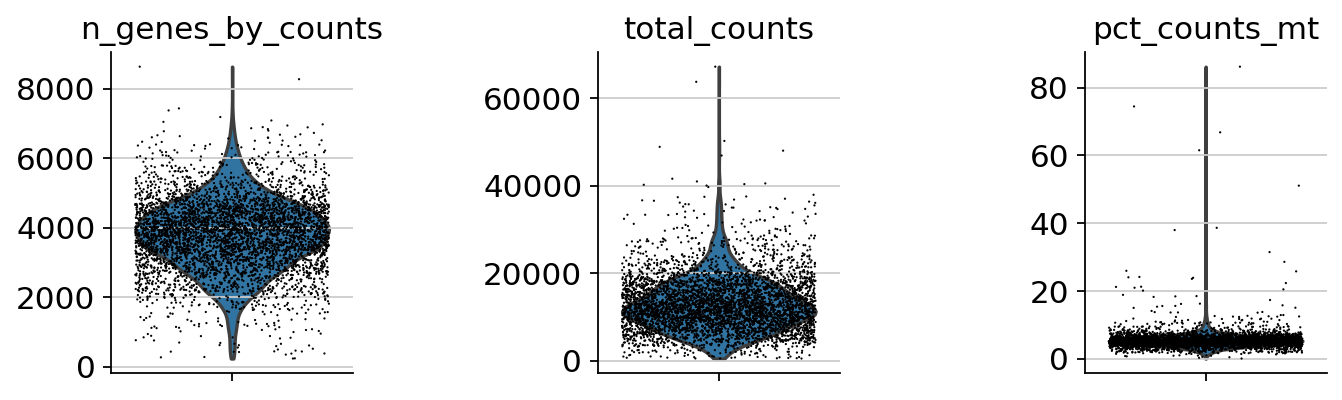

In [8]:
E14_hom.var['mt'] = E14_hom.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(E14_hom, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(E14_hom, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

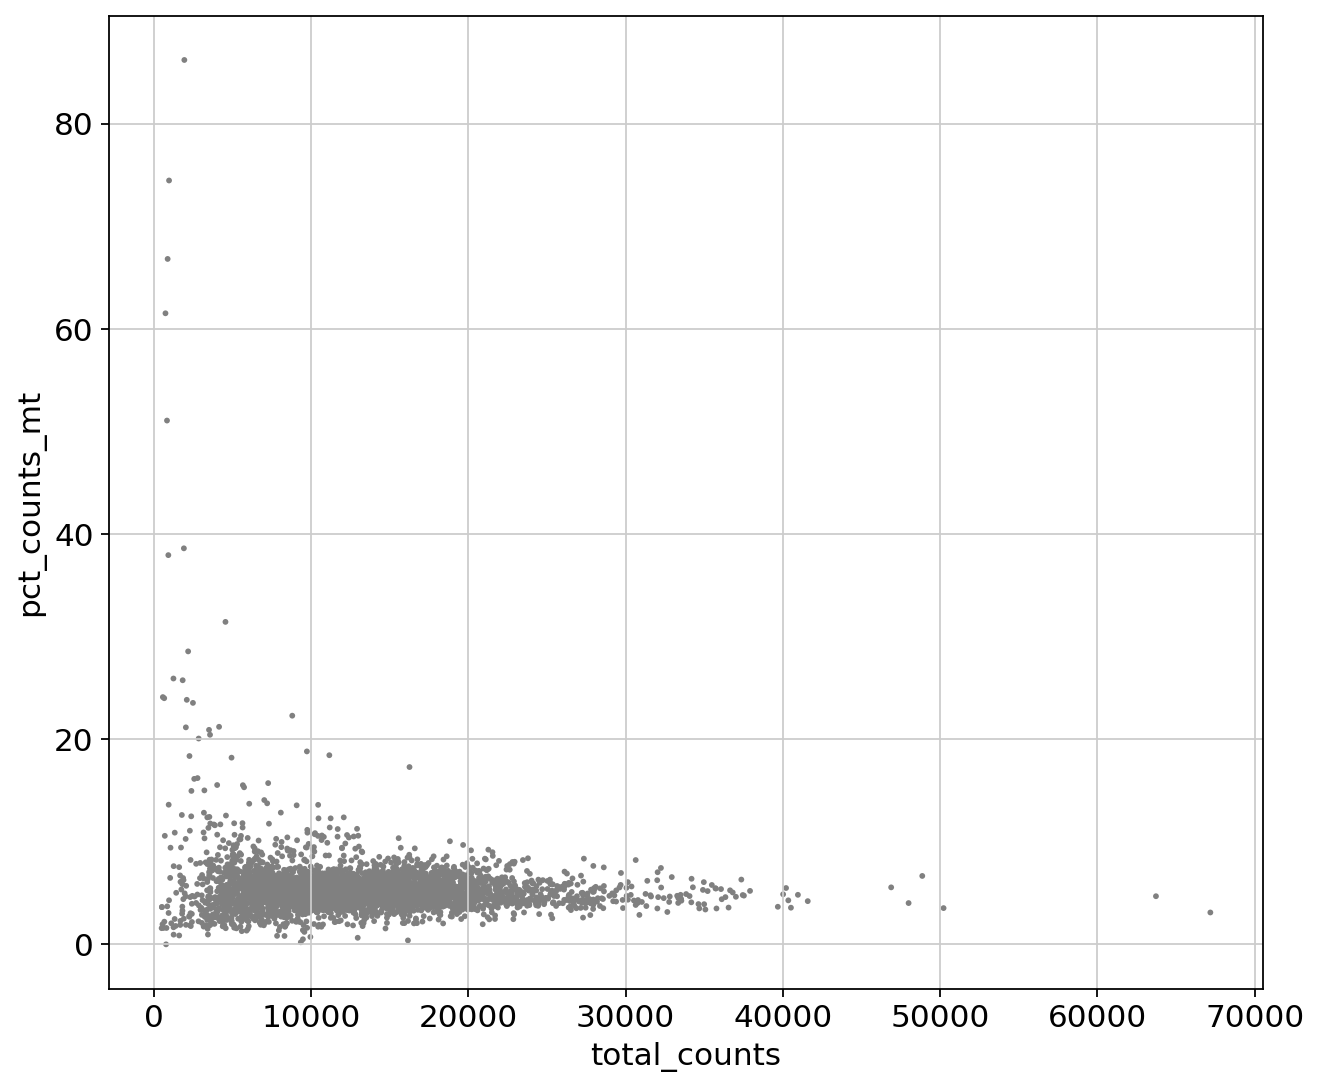

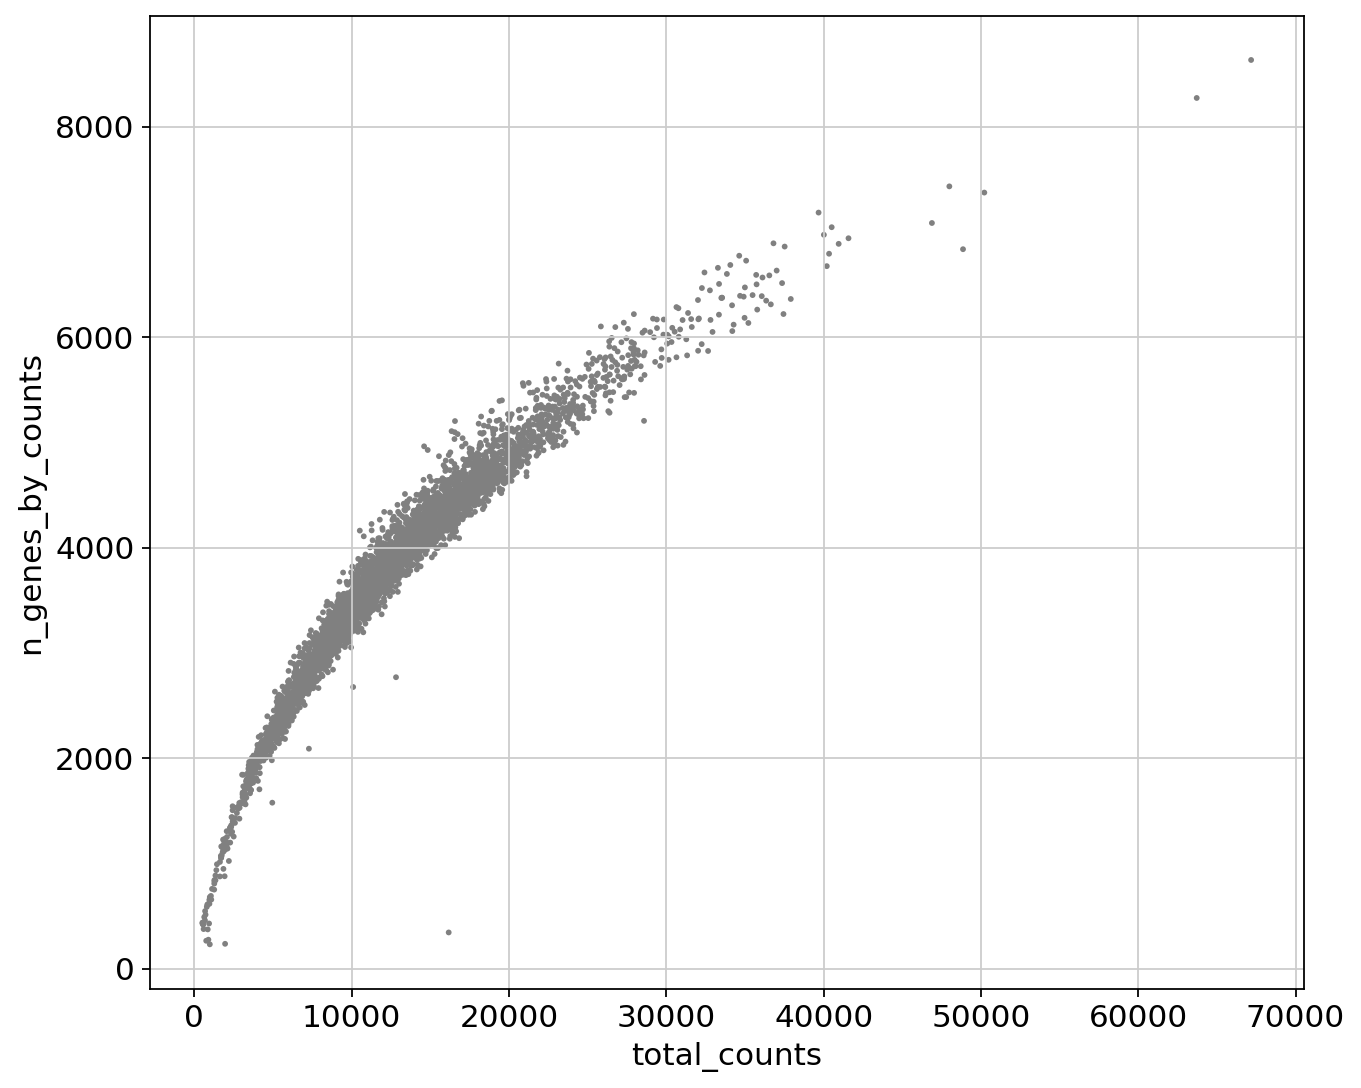

In [9]:
sc.pl.scatter(E14_hom, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(E14_hom, x='total_counts', y='n_genes_by_counts')

In [10]:
E14_hom = E14_hom[E14_hom.obs.n_genes_by_counts < 7000, :]
E14_hom = E14_hom[E14_hom.obs.pct_counts_mt < 10, :]
print(E14_hom)

View of AnnData object with n_obs × n_vars = 4301 × 16899
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.

Log normalise the data and identify highly variable genes.

normalizing counts per cell
    finished (0:00:00)


/home/marina/msc/dissertation/single_cell_analysis/.env/lib/python3.6/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


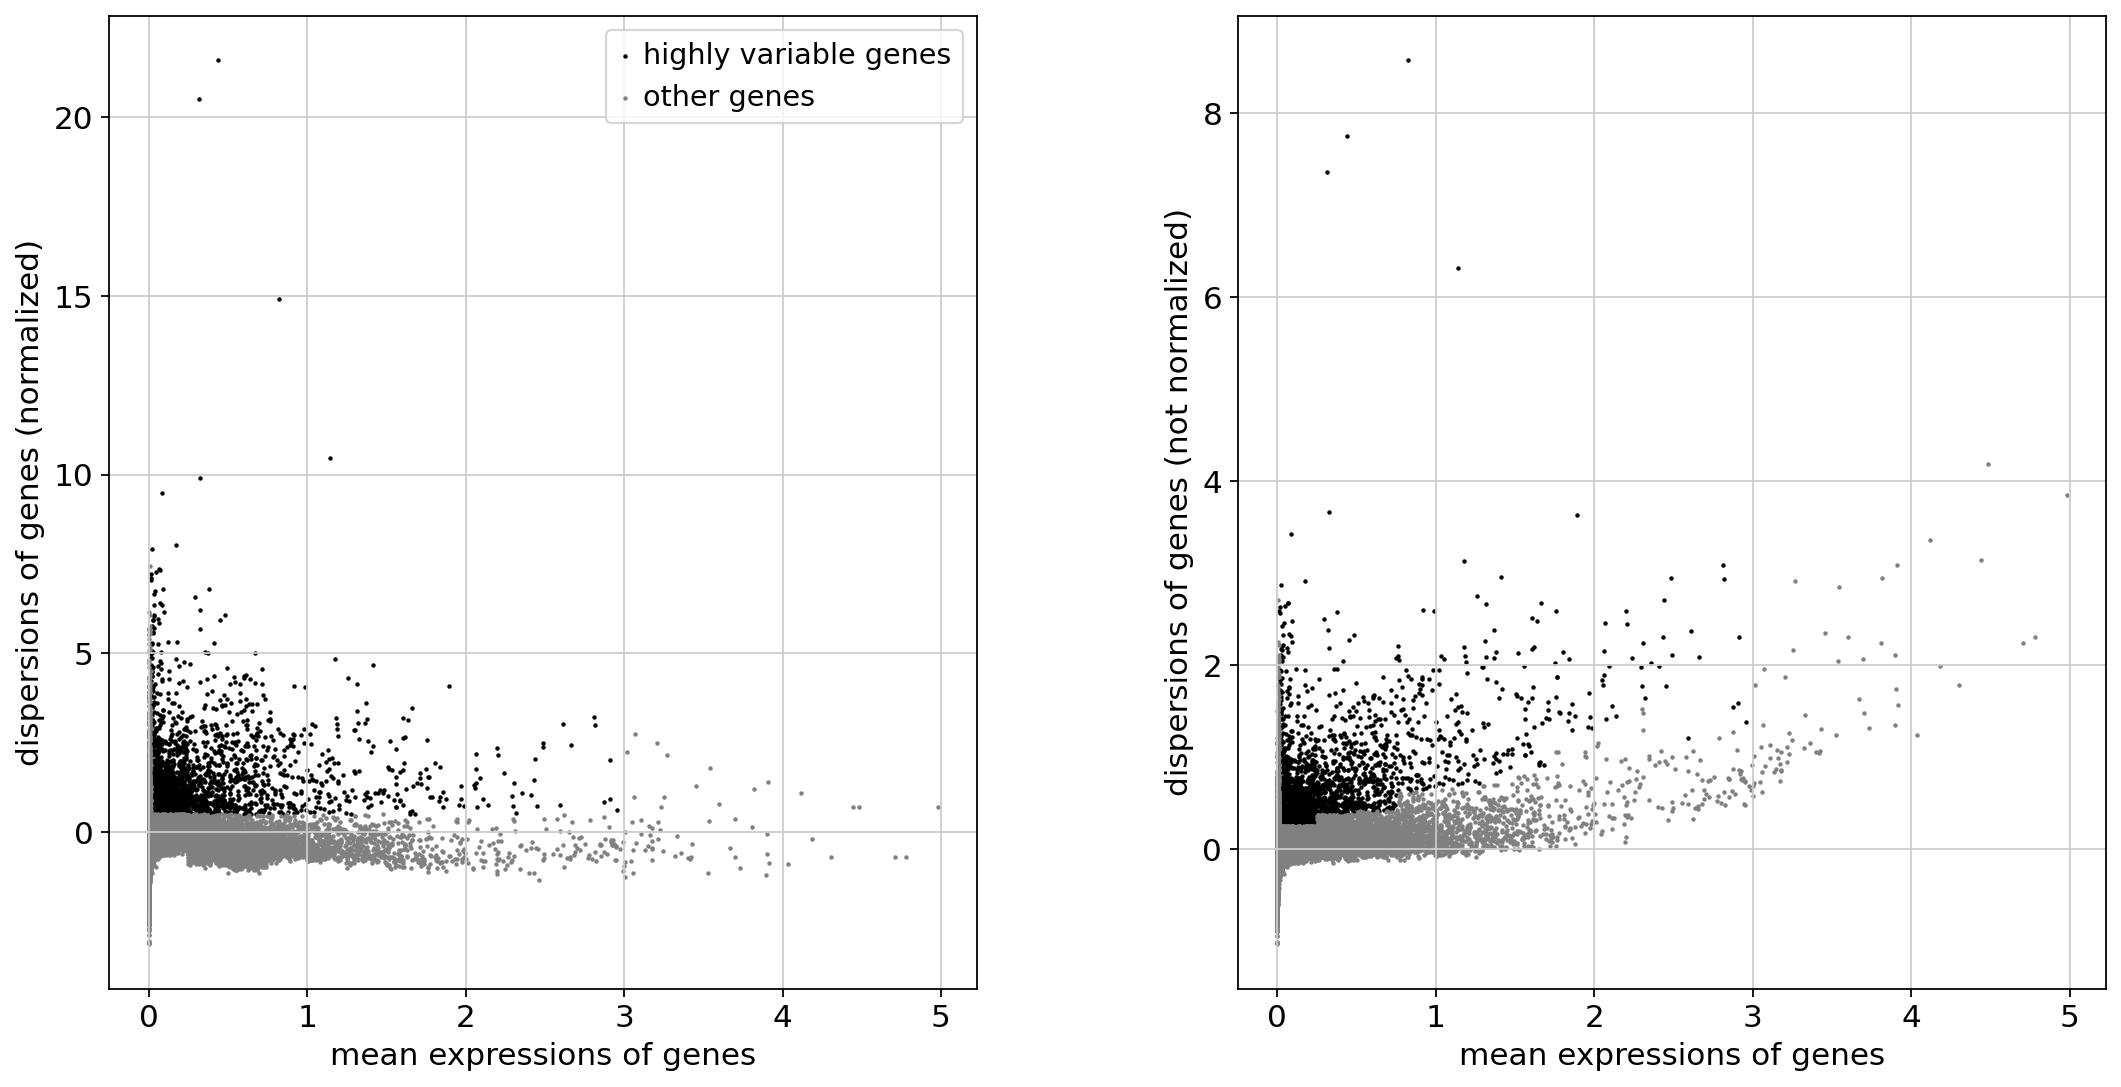

In [11]:
sc.pp.normalize_total(E14_hom, target_sum=1e4)
sc.pp.log1p(E14_hom)
sc.pp.highly_variable_genes(E14_hom, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(E14_hom)

Do the filtering and regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [12]:
E14_hom.raw = E14_hom
E14_hom = E14_hom[:, E14_hom.var.highly_variable]
sc.pp.regress_out(E14_hom, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(E14_hom, max_value=10)
print(E14_hom)

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:00:14)
AnnData object with n_obs × n_vars = 4301 × 2415
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p'


# Dimensionality Reduction

In [13]:
def draw_umap(data, labels, n_neighbors=5, min_dist=0.8, n_components=2, metric='euclidean', title=''):
    np.random.seed(42)
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    fig = plt.figure()
    if n_components == 1:
        ax = fig.add_subplot(111)
        scatter = ax.scatter(u[:,0], range(len(u)), c=labels, cmap='tab10', marker='.')
    if n_components == 2:
        ax = fig.add_subplot(111)
        scatter = ax.scatter(u[:,0], u[:,1], c=labels, cmap='tab10', marker='.')
    if n_components == 3:
        ax = fig.add_subplot(111, projection='3d')
        scatter = ax.scatter(u[:,0], u[:,1], u[:,2], c=labels, s=100, cmap='tab10', marker='.')
    
    legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Cell type")
    ax.add_artist(legend1)
    plt.title(title, fontsize=24)

In [ ]:
np.random.seed(42)
fit = umap.UMAP(
    n_neighbors=5,
    min_dist=0.8,
    n_components=2
)
print(fit)
embedding = fit.fit_transform(E14_hom)
print(embedding)

UMAP(min_dist=0.8, n_neighbors=5)


In [10]:
sc.pp.neighbors(E14_hom, n_neighbors=10, n_pcs=50)

computing neighbors
         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:01)


/home/marina/msc/dissertation/single_cell_analysis/.env/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 8006. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)


In [5]:
print(E14_hom)

AnnData object with n_obs × n_vars = 4446 × 30213


In [ ]:
# sc.tl.umap(E14_hom)
umap.UMAP().fit_transform(E14_hom)

## Marker genes for the Neural progenitors cell type

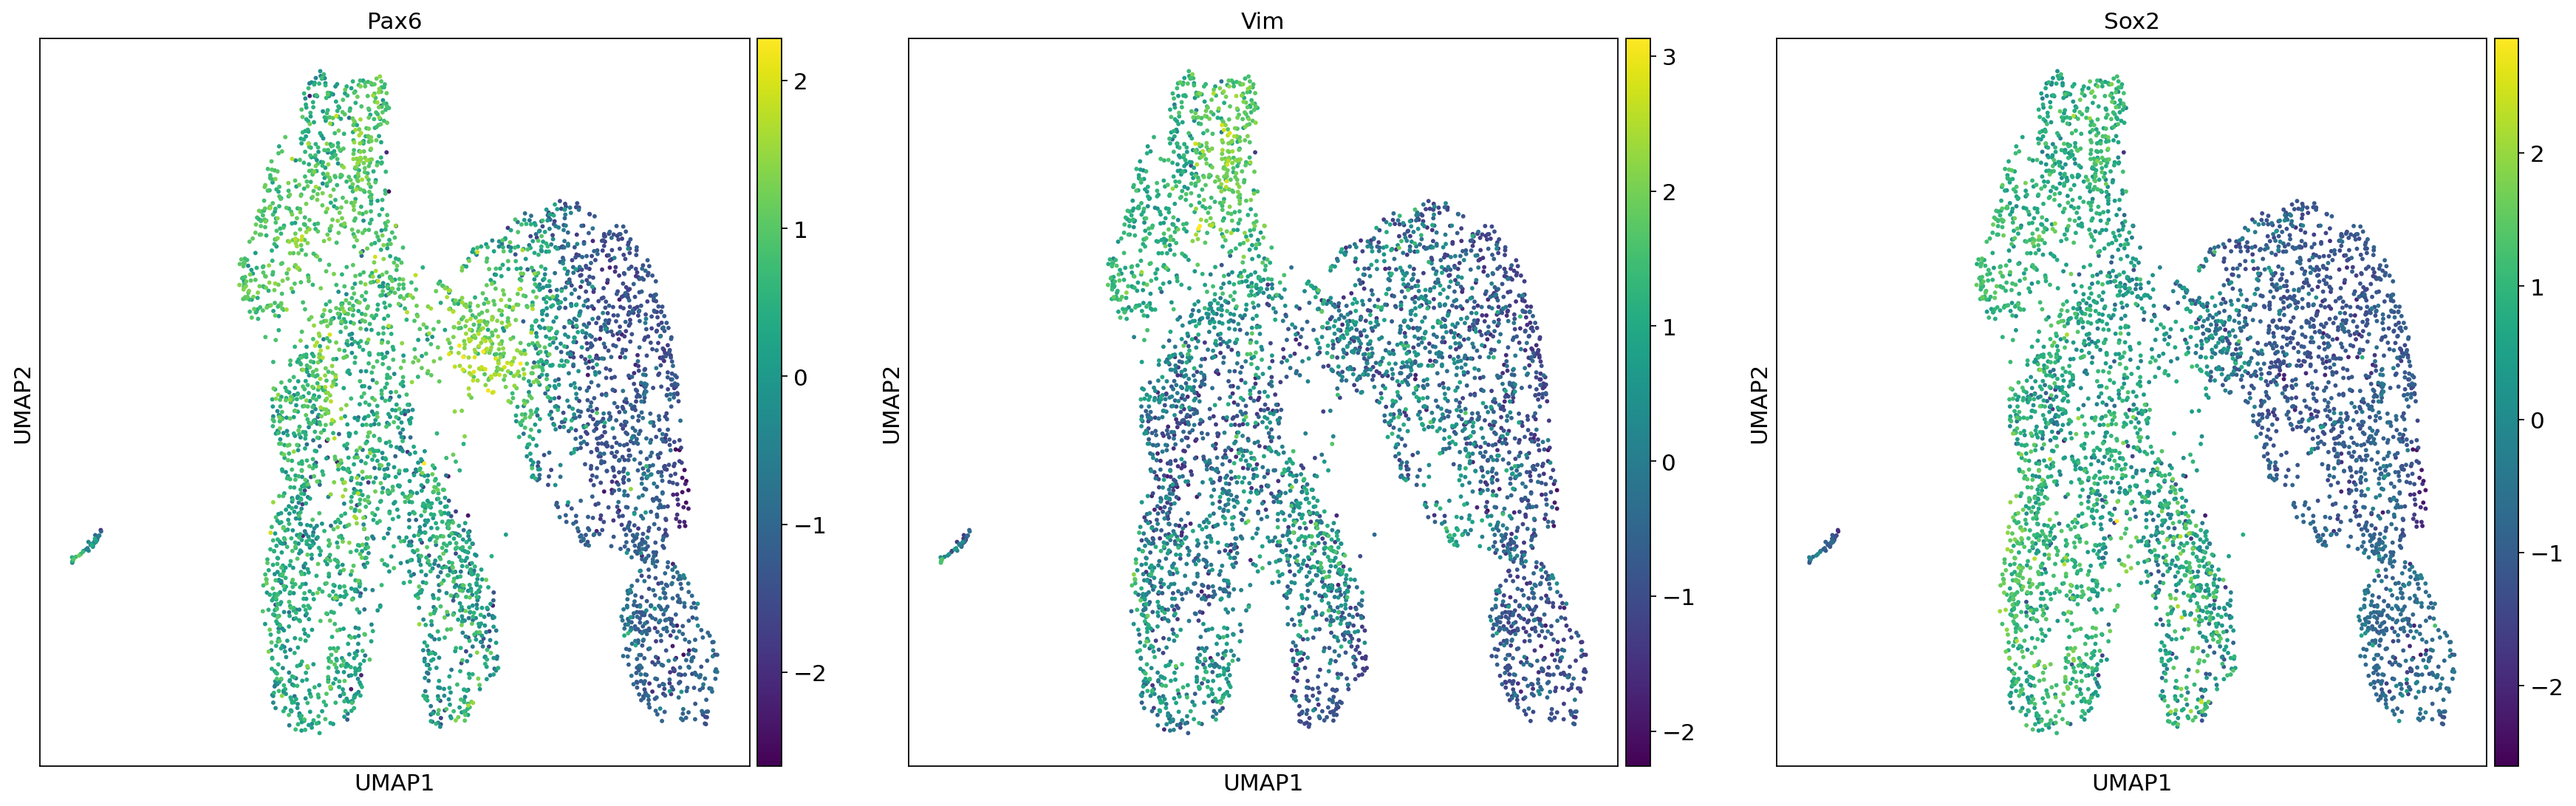

In [74]:
sc.pl.umap(E14_hom, color=['Pax6', 'Vim', 'Sox2'], use_raw=False)

## Marker genes for the Intermediate progenitors cell type

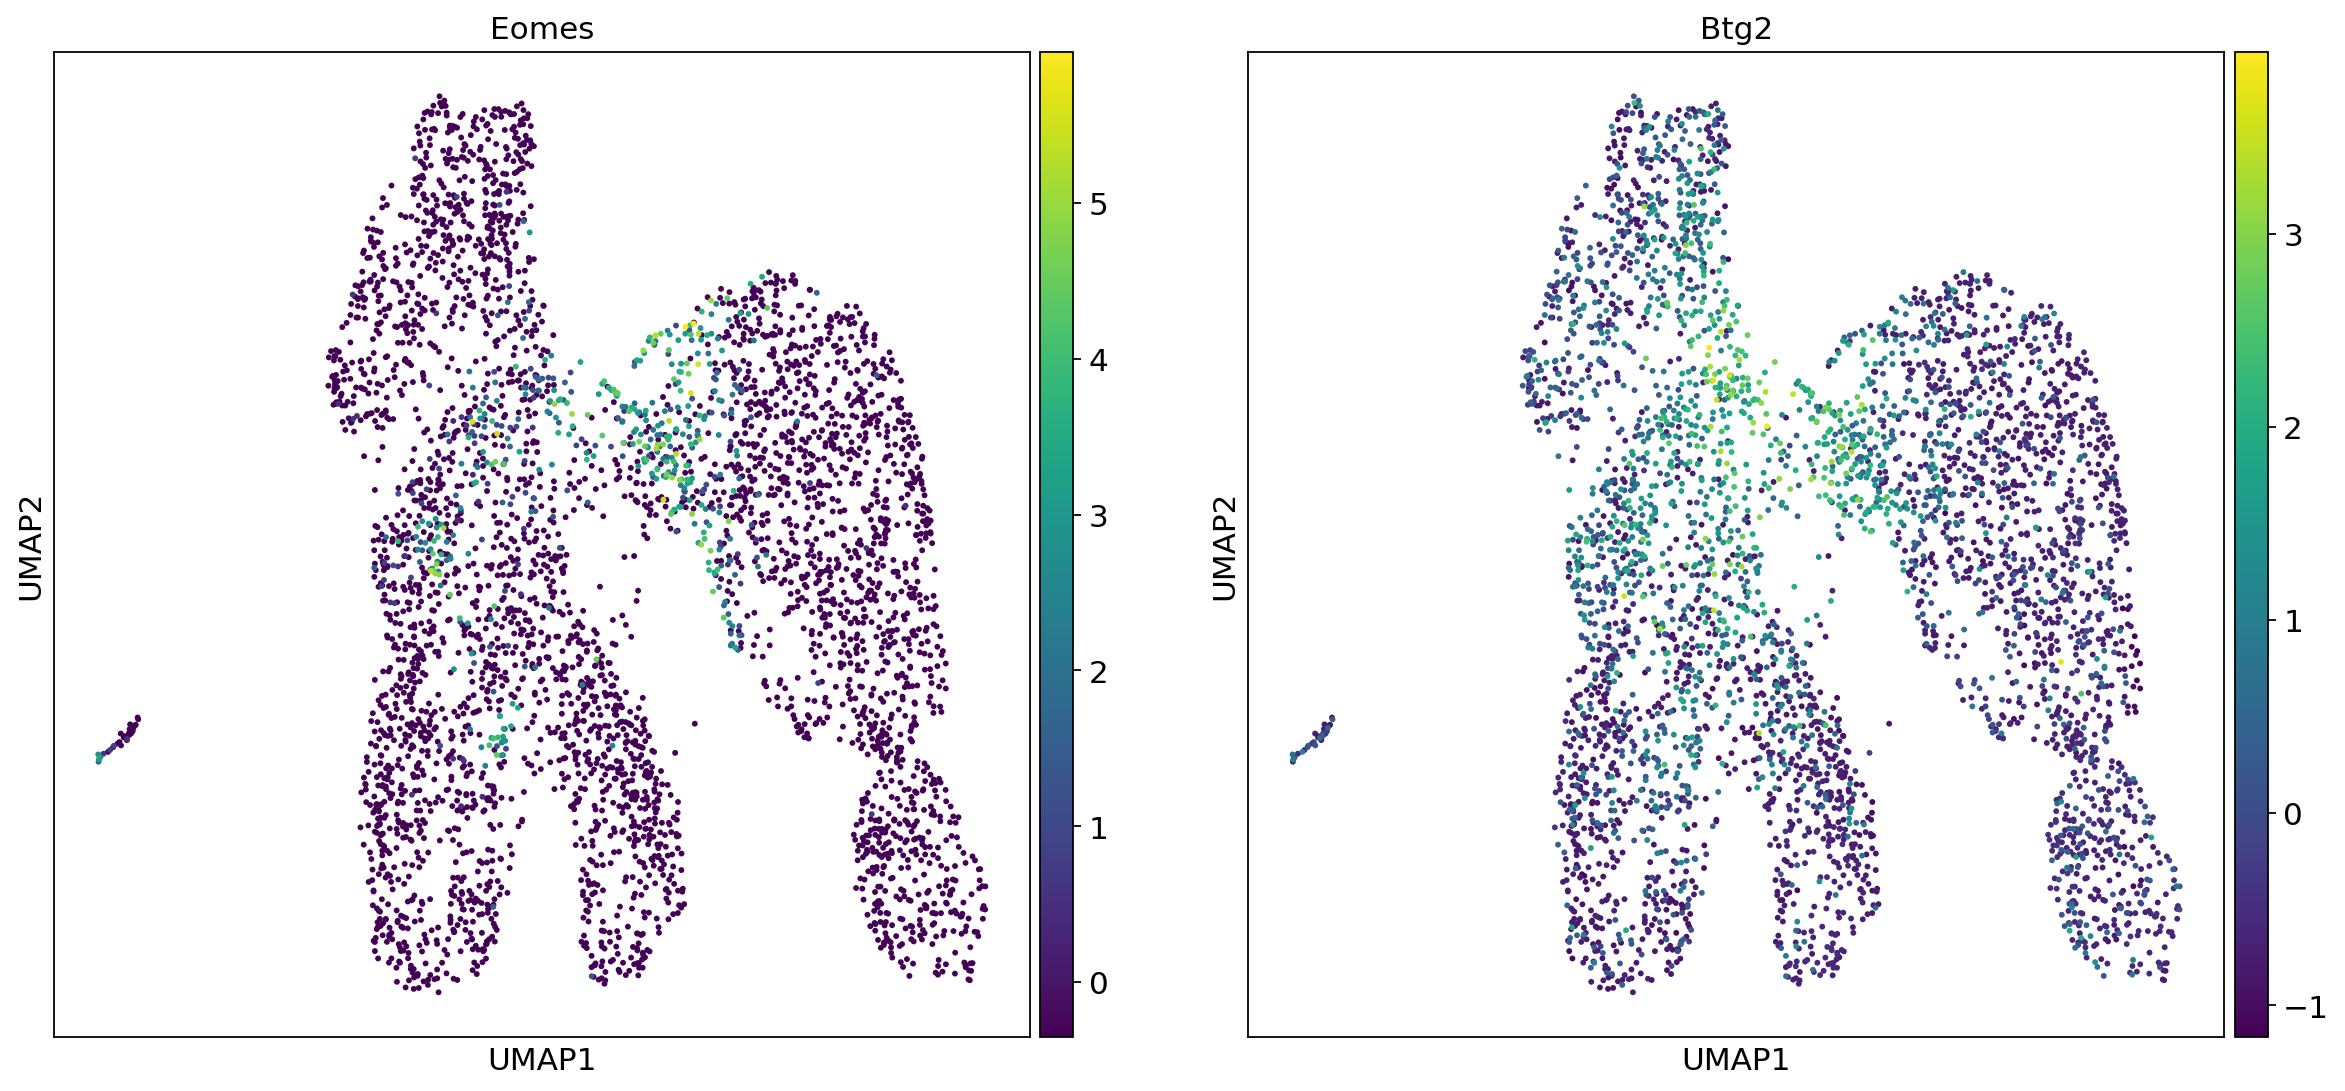

In [61]:
sc.pl.umap(E14_hom, color=['Eomes', 'Btg2'], use_raw=False)

## Marker genes for the Post-mitotic neurons cell type

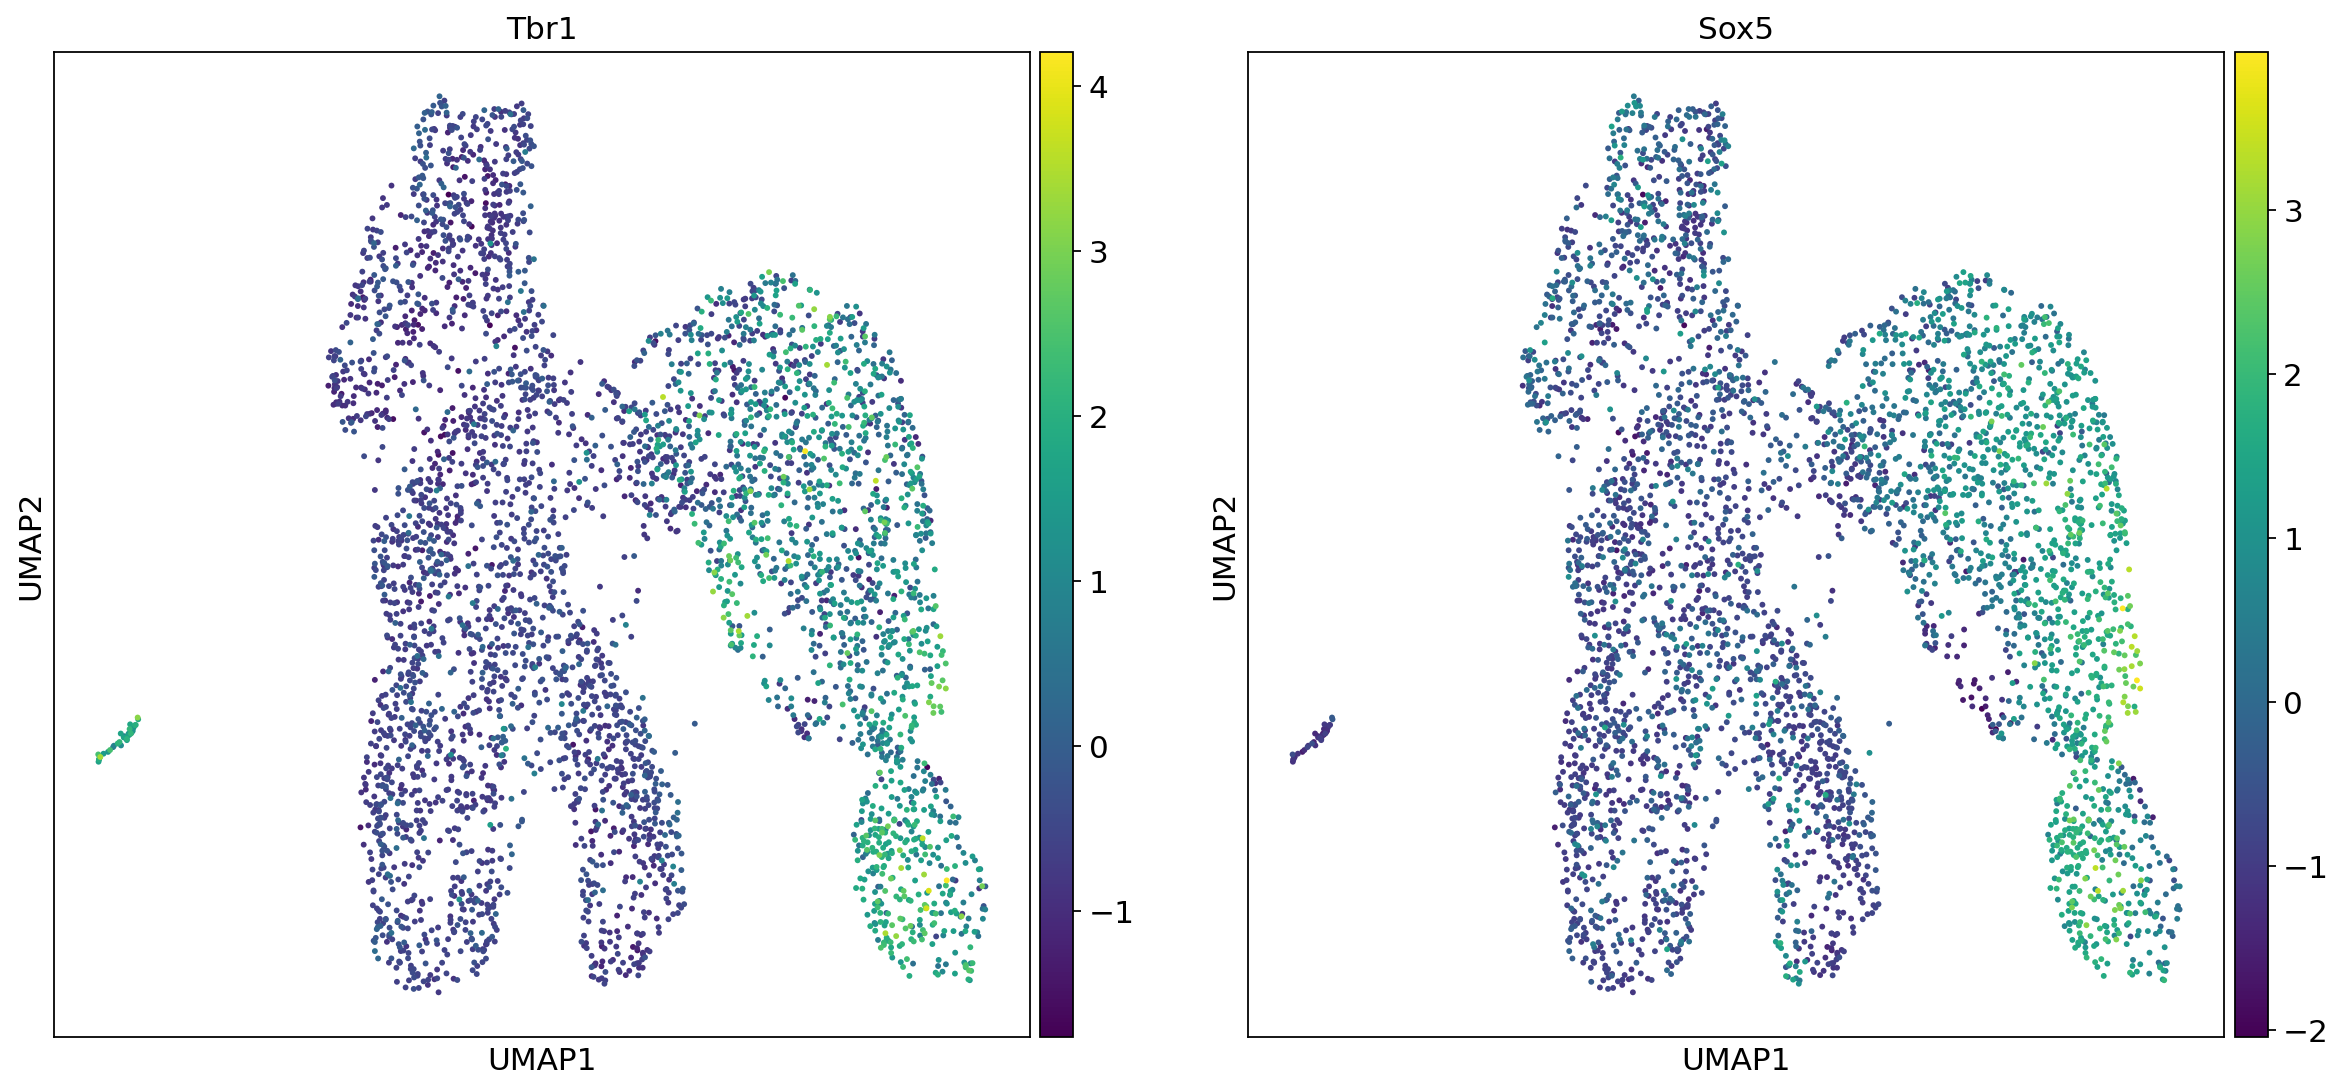

In [62]:
sc.pl.umap(E14_hom, color=['Tbr1', 'Sox5'], use_raw=False)

## Marker genes for the Ectopic cell type

In [67]:
sc.pl.umap(E14_hom, color=['Gsx2', 'Prdm13', 'Dlx1', 'Dlx2', 'Dlx5', 'Gad1', 'Gad2', 'Msx3', 'Helt'],
           palette="Set2", color_map=mpl.cm.Reds, use_raw=False)

NameError: name 'mpl' is not defined